# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Задача**  
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

### Загрузка библиотек

In [1]:
# Файлы и директории
import os

# Датафреймы
import pandas as pd

# Математика
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Генератор
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Константы
SEED = 12345
LABLES_PATH = '/datasets/faces/labels.csv'
FILES_PATH = '/datasets/faces/final_files/'

### Загрузка данных

In [2]:
# Данные о связях файла изображения и целевого признака
df = pd.read_csv(LABLES_PATH)

# Генератор данных для обучения
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=FILES_PATH,
        x_col='file_name',     # Признаки
        y_col='real_age',      # Целевая переменная
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',      # Регрессия
        seed=SEED)

Found 7591 validated image filenames.


#### Общая информация 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


#### Фотографии из датасета

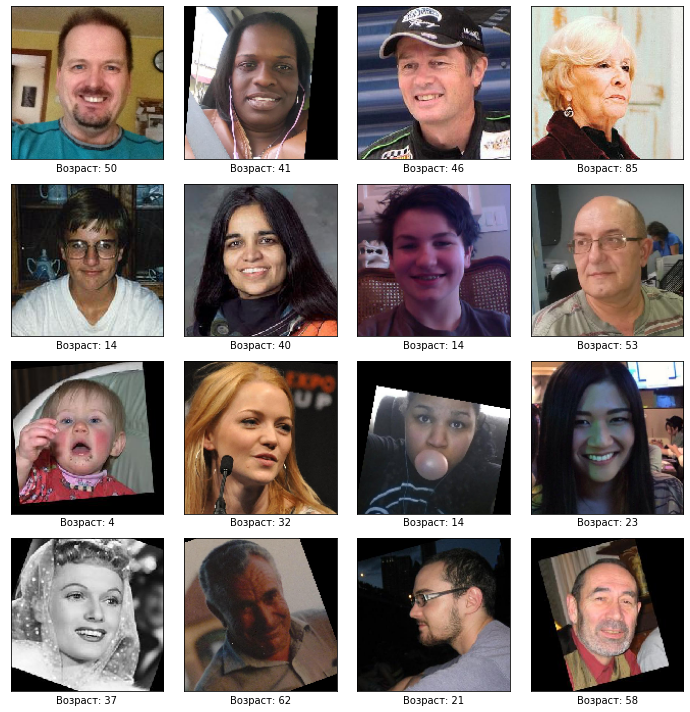

In [5]:
train, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(train[i])
    plt.xticks([])
    ax.set_xlabel(f"Возраст: {target[i]}")
    plt.yticks([])
    plt.tight_layout()

plt.show()

#### Распределение возрастов

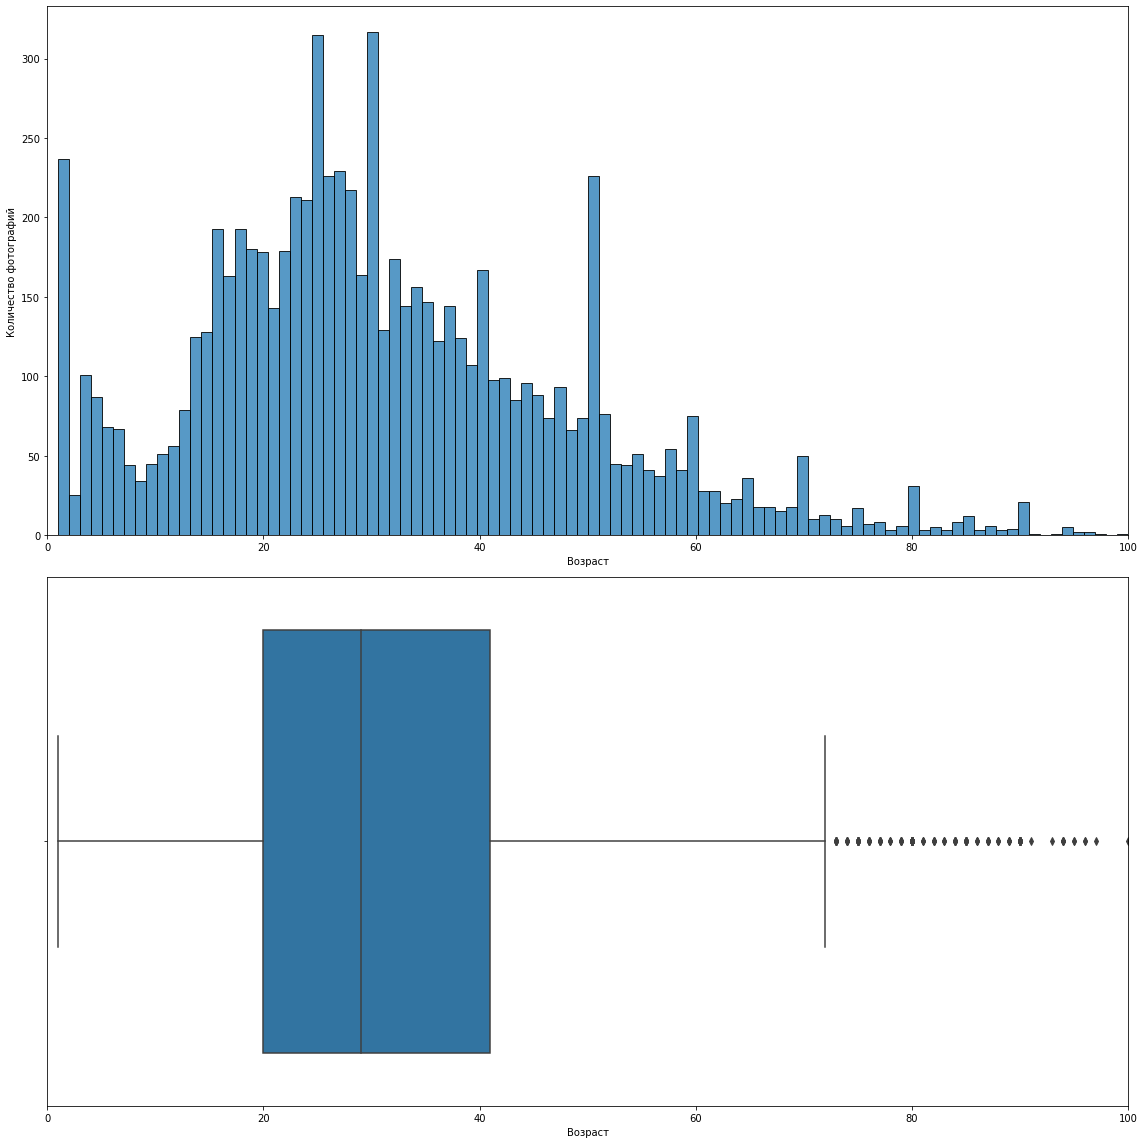

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

# Гистограмма
sns.histplot(df['real_age'],
             ax=axs[0],
             bins=df['real_age'].nunique())
axs[0].set_ylabel('Количество фотографий')

# Бокс-плот
sns.boxplot(x=df['real_age'], ax=axs[1])

# Лейблы и масштаб
for ax in axs:
    ax.set_xlabel('Возраст')
    ax.set_xlim(0, 100)
    
fig.tight_layout()
plt.show()

#### Статистики

Проверим общие параметры распределения целевой переменной:

In [7]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Проверим, какой возраст в датасете встречается чаще всего:

In [8]:
value_counts = df['real_age'].value_counts()
mode_df = pd.DataFrame(
    {'Возраст': value_counts.index,
     'Количество фото': value_counts.values})
mode_df.head(10)

,Возраст,Количество фото
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217
5,23,213
6,24,211
7,18,193
8,16,193
9,19,180


### Итоги этапа
* В наборе данных 7591 фотография, пропуски не обнаружены.
* Возраст людей на фото лежит в переделах от 1 года до 100 лет.
* Большая часть распределения целевого признака находится в пределах от 20 лет до 41 года.
* Фотографии сильно различаются между собой по качеству, цветопередаче и углу поворота.

Самые распространённые значения — 30 и 25 лет, которых заметно больше, чем других. Возможно, это связано с тем, как собирались данные.

## Обучение модели

### Код обучения модели

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

ADAM = Adam(lr=0.0003)
SEED = 12345

def load_train(path):

    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       brightness_range=(0.8, 1.))
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='traning',   
        seed=SEED)
    return train_datagen_flow

def load_test(path):

    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',   
        seed=SEED)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=ADAM,                               
                  loss='mse',   
                  metrics=['mae'])              
    return model

def train_model(model, train_data, test_data,      
                batch_size=None,            
                epochs=10,                   
                steps_per_epoch=None,       
                validation_steps=None):  
       
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size,                     
              epochs=epochs,                             
              steps_per_epoch=steps_per_epoch,           
              validation_steps=validation_steps,         
              verbose=2)                              
    return model
```

### Результат вывода на экран

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 78s - loss: 190.5012 - mae: 10.1414 - val_loss: 636.7060 - val_mae: 20.2134
Epoch 2/10
178/178 - 51s - loss: 91.5738 - mae: 7.2660 - val_loss: 530.6045 - val_mae: 17.9128
Epoch 3/10
178/178 - 52s - loss: 70.0204 - mae: 6.3533 - val_loss: 630.0709 - val_mae: 20.0155
Epoch 4/10
178/178 - 52s - loss: 52.4296 - mae: 5.4861 - val_loss: 183.5222 - val_mae: 10.6639
Epoch 5/10
178/178 - 50s - loss: 40.8586 - mae: 4.9043 - val_loss: 116.4843 - val_mae: 8.0259
Epoch 6/10
178/178 - 53s - loss: 34.6071 - mae: 4.4650 - val_loss: 77.9626 - val_mae: 6.6867
Epoch 7/10
178/178 - 52s - loss: 26.1306 - mae: 3.9087 - val_loss: 73.7879 - val_mae: 6.3353
Epoch 8/10
178/178 - 50s - loss: 19.9195 - mae: 3.4530 - val_loss: 81.3232 - val_mae: 6.8031
Epoch 9/10
178/178 - 51s - loss: 17.5222 - mae: 3.2152 - val_loss: 79.6640 - val_mae: 6.7302
Epoch 10/10
178/178 - 52s - loss: 15.9773 - mae: 3.0544 - val_loss: 72.7618 - val_mae: 6.4663

60/60 - 10s - loss: 72.7618 - mae: 6.4663
Test MAE: 6.4663
```

## Анализ обученной модели

Задачей проекта было построение модели, которая сможет по фотографии определить приблизительный возраст человека.

В ходе работы был проведён исследовательский анализ датасета с фотографиями людей и метками их возраста. Модель, построенная на архитектура ResNet, показала следующие результаты:  

* На 10-ти эпохах обучилась до метрики **MAE** = 6.4663
* Время обучения каждой из эпох лежит в переделах от 50 до 78 секунд

Получилось преодолеть пороговое значение **MAE** = 8, поэтому модель готова к внедрению. 

Так как модель в текущем состоянии всё ещё может ошибаться на 6 лет, для её улучшения можне предпринять следующие действия:

1. Добавить аугментацию с помощью поворотов изображений на небольшие углы. Это будет особенно полезно, так как в датасете много изображений под углом.
2. Добавить аугментацию с помощью отражения по горизонтали и незначительного масштабирования.
3. Изменить пропорции обучающей и валидационной выборок, например, до соотношения 80:20. Чем больше тренировочных данных, тем выше способность модели к обобщению.
4. Увеличить количество эпох. На данный момент, в процессе тренировки модели не наблюдается динамики к переобучению. Наоборот, на каждой эпохе **MAE** на валидационной выборке уменьшается.